<a href="https://colab.research.google.com/github/Squirtle007/CUDA-Q/blob/main/colab/v0.8.0/03_vqe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set up CUDA-Q Environment**

In [ ]:
#The following commands are used to set up the environment in Colab
%pip install cuda-quantum==0.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.8/148.8 MB 3.6 MB/s eta 0:00:00


# Cost Minimization

Below, we start with a basic example of a hybrid variational algorithm that involves flipping the Bloch vector of a qubit from the $|{0}\rangle$ state to the $|{1}\rangle$ state. First, we import the relevant packages and set our backend to simulate our workflow on NVIDIA GPUs.

In [ ]:
import cudaq
from typing import List

cudaq.set_target("nvidia")

In [ ]:
# Initialize a kernel/ ansatz and variational parameters.
@cudaq.kernel
def kernel(angles: List[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(angles[0], qubit)
    ry(angles[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = cudaq.spin.z(0)

# Initial gate parameters which intialize the qubit in the zero state
initial_parameters = [0, 0]

print(cudaq.draw(kernel, initial_parameters))

     ╭───────╮╭───────╮
q0 : ┤ rx(0) ├┤ ry(0) ├
     ╰───────╯╰───────╯



We build our cost function such that its minimal value corresponds to the qubit being in the $|{1}\rangle$ state. The `observe` call below allows us to simulate our state vector $|{\psi}\rangle$ and calculate

$$ \langle \psi | Z | \psi \rangle. $$

In [ ]:
cost_values = []


def cost(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(kernel, hamiltonian,
                                      parameters).expectation()
    cost_values.append(expectation_value)
    return expectation_value

In [ ]:
# We see that the initial value of our cost function is one, demonstrating that our qubit is in the zero state
initial_cost_value = cost(initial_parameters)
print(initial_cost_value)

1.0


Below we use our built-in optimization suite to minimize the cost function. We will be using the gradient-free COBYLA alogrithm.

In [ ]:
# Define a CUDA-Q optimizer.
optimizer = cudaq.optimizers.COBYLA()
optimizer.initial_parameters = initial_parameters

result = optimizer.optimize(dimensions=2, function=cost)

Text(0, 0.5, 'Cost Value')

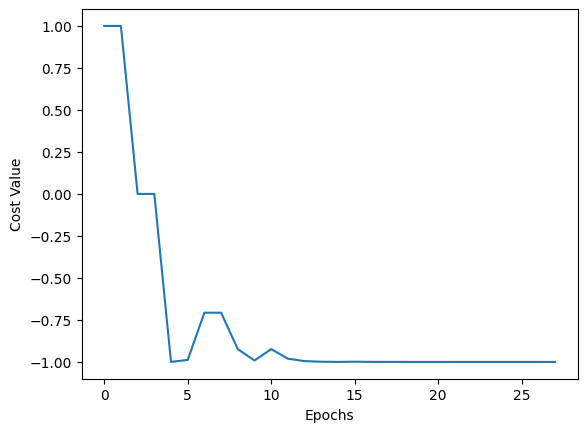

In [ ]:
# Plotting how the value of the cost function decreases during the minimization procedure.
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")

We see that the final value of our cost function,

$$ \langle \psi | Z | \psi \rangle = -1, $$

demonstrating that the qubit is in the $|{1}\rangle$ state.

# Variational Quantum Eigensolver

A common application of the Variational Quantum Eigensolver (VQE) algorithm is to compute the ground state energy of a molecular system. The code below demonstrates how to perform classical preprocessing for a $H_2$ molecule (i.e. obtain the integrals from a Hartree-Fock computation to build the molecular Hamiltonian), prepare the initial Hartree-Fock state on the quantum register, add the parameterized UCCSD ansatz to the kernel, and select the COBYLA optimizer.  We are then ready to call `cudaq:vqe` to estimate the minimum energy of the system.

In [ ]:
!pip install openfermionpyscf==0.5

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.1 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=39ac75814391279dfb6e0905b32beb0bc26d4fda587a51294461400bb63a6a92
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [ ]:
import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# Single precision
cudaq.set_target("nvidia")
# Double precision
#cudaq.set_target("nvidia-fp64")

The problem of interest here is a chain of hydrogen atoms seperated along the z-axis at a fixed interval called the bond distance.

The interatomic electrostatic forces due to the electrons and protons and the shielding by the neutrons creates a chemical system whose energy can be minimised to find a stable configuration.

Let us first begin by defining the molecule and other metadata about the problem.


In [ ]:
# Number of hydrogen atoms.
hydrogen_count = 2

# Distance between the atoms in Angstroms.
bond_distance = 0.7474

# Define a linear chain of Hydrogen atoms
geometry = [('H', (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

molecule, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)

electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

We now generate a Unitary Coupled-Cluster Singles and Doubles (UCCSD) ansatz from the template provided by CUDA-Q.  

In [ ]:
@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

### Using CUDA-Q Optimizers

We use the builtin optimizers within CUDA-Q for the minimization procedure.

In [ ]:
optimizer = cudaq.optimizers.COBYLA()

energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(energy)

-1.1371740035195181


### Integration with Third-Party Optimizers

We can also integrate popular libraries like scipy with CUDA-Q.

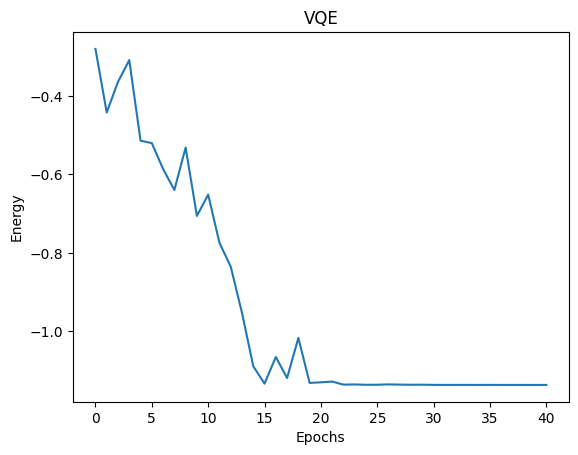

In [ ]:
# Define a function to minimize
def cost(theta):

    exp_val = cudaq.observe(kernel, molecule, theta).expectation()

    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, np.pi, parameter_count)

# Use the scipy optimizer to minimize the function of interest
result = minimize(cost,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 40})

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

# Quantum Approximate Optimization Algorithm

Here we build up a kernel for QAOA with `p` layers, with each layer containing the alternating set of unitaries corresponding to the problem and the mixer Hamiltonians. The algorithm leverages the VQE algorithm to compute the Max-Cut of a 3-regular (each node connects with 3 edges) graph generated below.

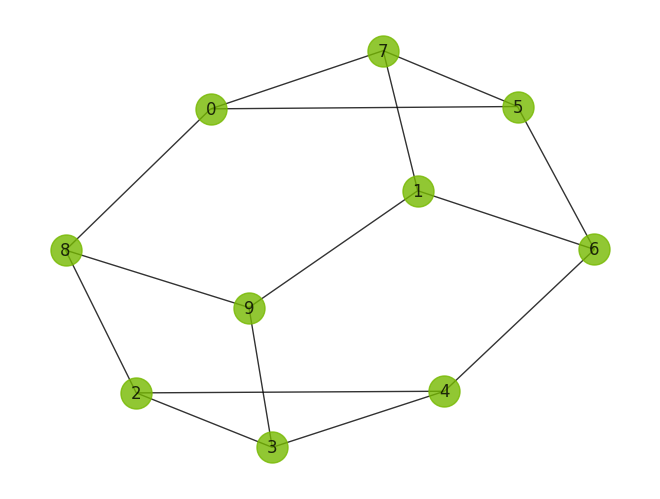

In [ ]:
import networkx as nx
import random

num_nodes = 10

random.seed(13)
edges = nx.random_regular_graph(3, num_nodes).edges()
G = nx.Graph()
G.add_edges_from(edges)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500, node_color='#76B900')

In [ ]:
import cudaq
from cudaq import spin

from typing import List

import numpy as np



# The problem Hamiltonian
hamiltonian = 0    # Initialize the hamiltonian object
for (i, j) in edges:
    hamiltonian += 0.5 * spin.z(i) * spin.z(j)


# Problem parameters.
qubit_count = num_nodes
layer_count: int = 2
parameter_count: int = 2 * layer_count


@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float]):
    """QAOA ansatz for Max-Cut"""
    qvector = cudaq.qvector(qubit_count)

    # Create superposition
    h(qvector)

    # Loop over the layers
    for layer in range(layer_count):
        # Loop over the qubits
        # Problem unitary
        for qubit in range(qubit_count):
            x.ctrl(qvector[qubit], qvector[(qubit + 1) % qubit_count])
            rz(2.0 * thetas[layer], qvector[(qubit + 1) % qubit_count])
            x.ctrl(qvector[qubit], qvector[(qubit + 1) % qubit_count])

        # Mixer unitary
        for qubit in range(qubit_count):
            rx(2.0 * thetas[layer + layer_count], qvector[qubit])


# Specify the optimizer and its initial parameters. Make it repeatable.
cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.COBYLA()
np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)
print(cudaq.draw(kernel_qaoa, qubit_count, layer_count, optimizer.initial_parameters))

Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064]
     ╭───╮                                                                   »
q0 : ┤ h ├──●──────────────────●─────────────────────────────────────────────»
     ├───┤╭─┴─╮╭────────────╮╭─┴─╮                                           »
q1 : ┤ h ├┤ x ├┤ rz(0.4362) ├┤ x ├──●──────────────────●─────────────────────»
     ├───┤╰───╯╰────────────╯╰───╯╭─┴─╮╭────────────╮╭─┴─╮                   »
q2 : ┤ h ├────────────────────────┤ x ├┤ rz(0.4362) ├┤ x ├──●────────────────»
     ├───┤                        ╰───╯╰────────────╯╰───╯╭─┴─╮╭────────────╮»
q3 : ┤ h ├────────────────────────────────────────────────┤ x ├┤ rz(0.4362) ├»
     ├───┤                                                ╰───╯╰────────────╯»
q4 : ┤ h ├───────────────────────────────────────────────────────────────────»
     ├───┤                                                                   »
q5 : ┤ h ├───────────────

In [ ]:
import time


# Define the simulation target:
cudaq.set_target("nvidia")  # "nvidia" for GPU, "qpp-cpu" for CPU


# Define the objective, return `<state(params) | H | state(params)>`
def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, layer_count,
                         parameters).expectation()


# Optimize!
t0 = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)
print("Execution time =", round(time.time()-t0, 3), "(s)")

# Print the optimized value and its parameters
print("Optimal value = ", optimal_expectation)
print("Optimal parameters = ", optimal_parameters)

# Sample the circuit using the optimized parameters
counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, optimal_parameters, shots_count=2**18)
print(counts)

max = 0
for bitstring in counts:
    if counts[bitstring] > max:
        max = counts[bitstring]
        bitstring_max = bitstring
print("The optimal bitstring with max. number of shots =", bitstring_max)

Execution time = 4.524 (s)
Optimal value =  -0.8334639233087202
Optimal parameters =  [2.4441432374826286, -0.6456565620029694, -0.14621208106008962, -0.3386795792490146]
{ 1011111111:4 1101111111:3 1001111111:41 0001111111:34 1010111111:41 0100111111:26 1111011111:6 0111011111:6 1011011111:12 0001011111:8 1010011111:24 0010011111:16 1100011111:32 0100011111:9 1101101111:19 0001101111:101 0110101111:91 1100101111:29 1000101111:6 0111001111:74 0101001111:86 1001001111:14 0001001111:105 1110001111:34 0110001111:92 1010001111:5 0100001111:31 1000001111:16 0111110111:5 1011110111:22 0101110111:153 1001110111:55 0001110111:215 1110110111:19 1010110111:72 0100110111:402 1000110111:76 1011010111:80 1001010111:115 1010010111:47 0010010111:461 1100010111:8 1000010111:24 0001100111:493 1110100111:33 0110100111:448 1101000111:7 1001000111:128 0001000111:185 1011000111:86 0110000111:118 1111111011:6 0111111011:21 0011111011:1 1110111011:7 0010111011:383 0100111011:472 0111011011:381 1011011011:412